# imports

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader, Data
from torchvision import transforms
from torchvision.io import read_image
import pandas as pd
import os
import numpy as np
import cv2  # OpenCV for image processing
import matplotlib.pyplot as plt

#Hyper Parameters

In [ ]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_dir = '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL'
excel_file = '/content/drive/MyDrive/input/insat_3d_ds-Sheet.csv'
num_epochs = 100
batch_size = 8
learning_rate = 0.001

# Feature Extractors

In [ ]:
# Function to extract edges and their angles from an image
def extract_edges_and_angles(image):
    image_np = image.permute(1, 2, 0).cpu().numpy() * 255.0  # Convert to [0, 255] range
    image_np = image_np.astype(np.uint8)

    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    angles = []

    for contour in contours:
        if len(contour) >= 5:
            [vx, vy, x, y] = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            angle = np.arctan2(vy, vx) * (180.0 / np.pi)
            angles.append(angle)

    angles = np.array(angles)
    return edges, angles

# Load data function
def load_data(image_dir, excel_file):
    df = pd.read_csv(excel_file)
    intensities = df['label'].values

    data_list = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['img_name'])
        image = read_image(img_path).float() / 255.0
        image = transforms.Resize((64, 64))(image)

        node_features = image.permute(1, 2, 0).reshape(-1, image.shape[0])

        edges, angles = extract_edges_and_angles(image)

        edge_index = torch.tensor(np.argwhere(edges > 0).T, dtype=torch.long)
        edge_index = torch.stack((edge_index[0], edge_index[1]))

        # Ensure edge_attr is calculated based on the number of edges
        num_edges = edge_index.size(1)

        if num_edges > 0:
            # Create edge_attr corresponding to edge_index
            edge_attr = torch.tensor(angles[:num_edges], dtype=torch.float).view(-1, 1)
        else:
            edge_attr = torch.empty((0, 1), dtype=torch.float)

        # Adjust edge_attr to match the number of edges
        if edge_attr.shape[0] < num_edges:
            edge_attr = torch.cat([edge_attr, torch.zeros(num_edges - edge_attr.shape[0], 1, dtype=torch.float)])
        elif edge_attr.shape[0] > num_edges:
            edge_attr = edge_attr[:num_edges]

        # Create a PyTorch Geometric data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([intensities[idx]]).float())
        data_list.append(data)

    return data_list

# Features of image

Edges

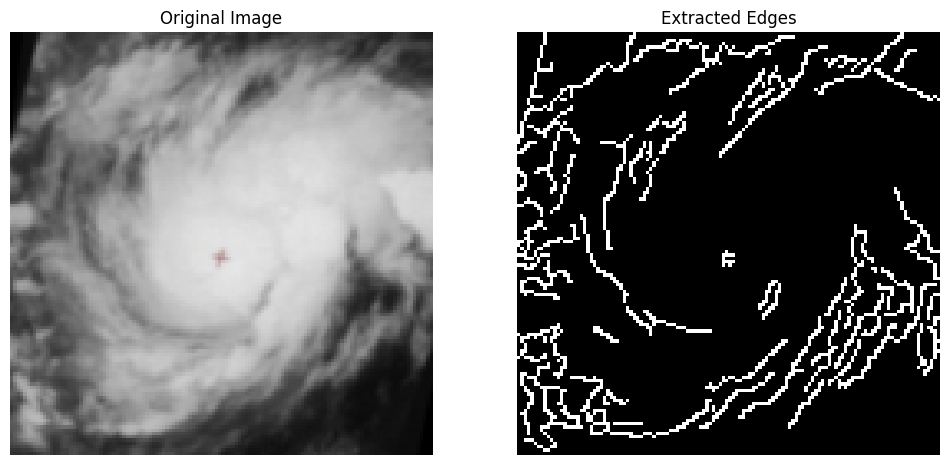

In [ ]:
import matplotlib.pyplot as plt

def visualize_image_features(image, edges):
    # Convert the image tensor to a NumPy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Display the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # Display the edges
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Extracted Edges")
    plt.axis('off')

    plt.show()

# Example usage for one image
# Assuming you have a sample image from the data
sample_image = read_image('/content/drive/MyDrive/input/augmented_raw_/85_aug_3.jpg').float() / 255.0
sample_image = transforms.Resize((128,128))(sample_image)
edges, _ = extract_edges_and_angles(sample_image)
visualize_image_features(sample_image, edges)


Nodes and Edges

Filtered Edge Index Shape: torch.Size([2, 132])


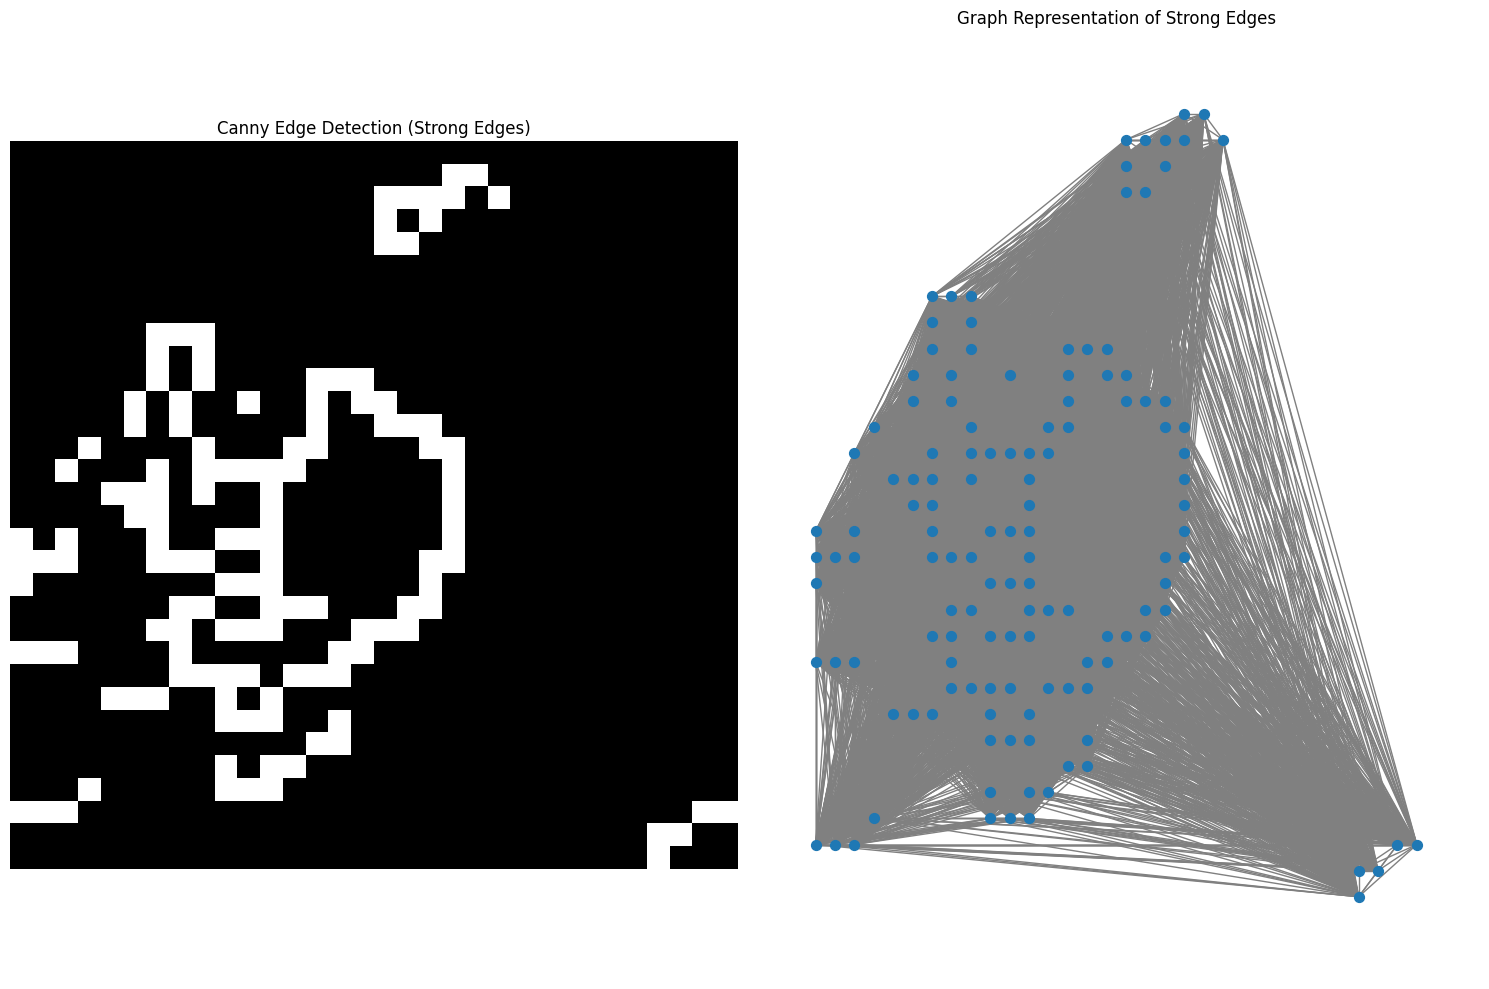

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import networkx as nx

image_path = '/content/drive/MyDrive/input/augmented_raw_/45(3)_aug_4.jpg'  # Ensure this path is correct
image = cv2.imread(image_path)

image_resized = cv2.resize(image, (32,32))

gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 100, 200)

edge_indices = np.argwhere(edges > 0)
edge_strengths = edges[edge_indices[:, 0], edge_indices[:, 1]]

edge_index_sample = torch.tensor(edge_indices.T, dtype=torch.long)

threshold = 100
strong_edges = edge_strengths > threshold

filtered_edge_index = edge_index_sample[:, strong_edges]
print("Filtered Edge Index Shape:", filtered_edge_index.shape)

G = nx.Graph()

for j in range(filtered_edge_index.shape[1]):
    x = filtered_edge_index[0, j].item()
    y = filtered_edge_index[1, j].item()
    G.add_node((x, y))

    for k in range(filtered_edge_index.shape[1]):
        if j != k:
            x_end = filtered_edge_index[0, k].item()
            y_end = filtered_edge_index[1, k].item()
            G.add_edge((x, y), (x_end, y_end))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(edges, cmap='gray')
axs[0].set_title("Canny Edge Detection (Strong Edges)")
axs[0].axis('off')

mirrored_pos = {node: (node[1],32-node[0]) for node in G.nodes()}

nx.draw(G, mirrored_pos, node_size=50, edge_color='gray', with_labels=False, ax=axs[1])
axs[1].set_title("Graph Representation of Strong Edges")
axs[1].grid()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


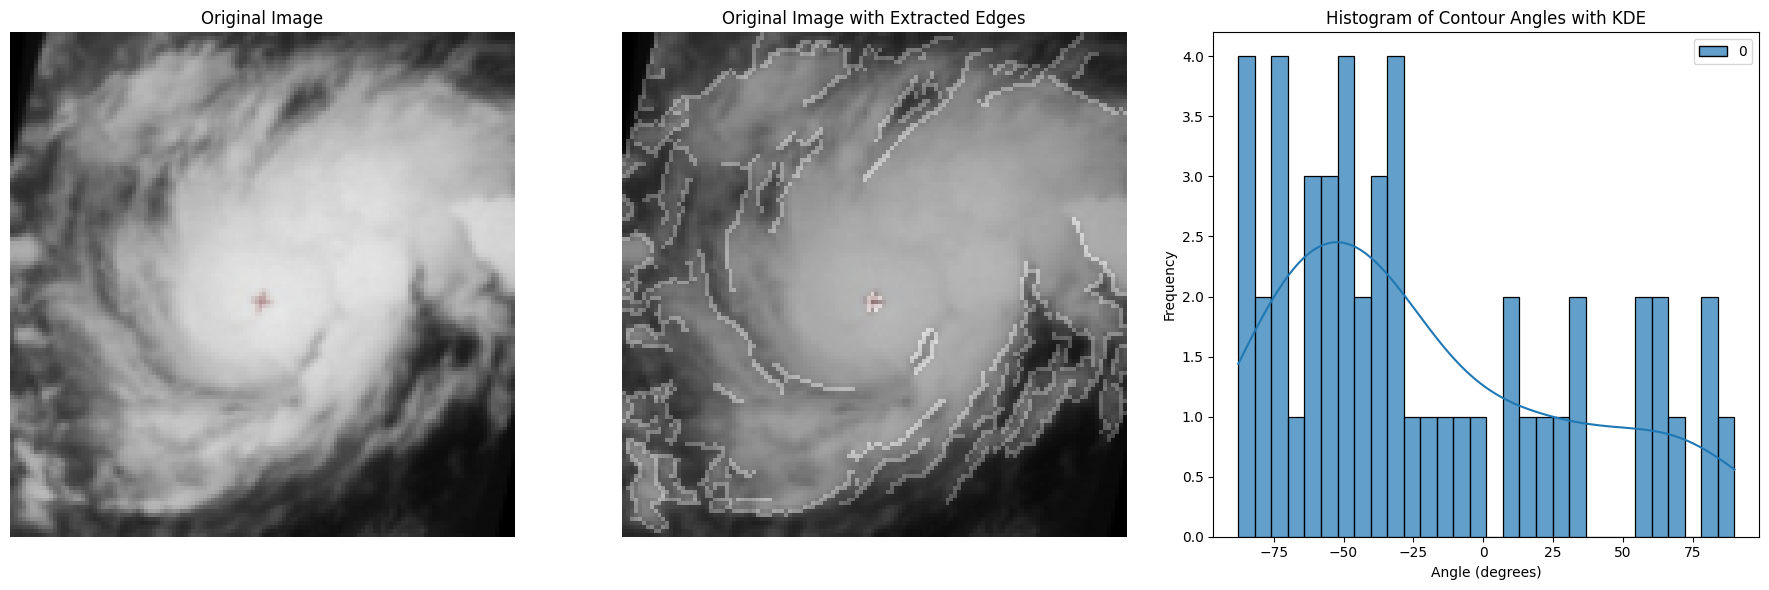

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Improved visualization function for edges and angles
def visualize_edges_and_angles(image_tensor):
    edges, angles = extract_edges_and_angles(image_tensor)

    # Convert image tensor back to numpy for visualization
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy() * 255.0  # Scale back to [0, 255]
    image_np = image_np.astype(np.uint8)  # Convert to uint8

    # Plot the original image, edges, and angle histogram with KDE
    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # Overlay Edges on the Original Image
    plt.subplot(1, 3, 2)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to 3-channel for blending
    combined_image = cv2.addWeighted(image_np, 0.8, edges_colored, 0.2, 0)  # Blend images
    plt.imshow(combined_image)
    plt.title("Original Image with Extracted Edges")
    plt.axis('off')

    # Histogram of Contour Angles with KDE
    plt.subplot(1, 3, 3)
    sns.histplot(angles, bins=30, color='orange', kde=True, alpha=0.7)
    plt.title("Histogram of Contour Angles with KDE")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Load and process the image
image_tensor = read_image("/content/drive/MyDrive/input/augmented_raw_/85_aug_3.jpg").float() / 255.0
image_tensor = transforms.Resize((128,128))(image_tensor)
visualize_edges_and_angles(image_tensor)


<ipython-input-86-4687b303dde1>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - length * vx)
<ipython-input-86-4687b303dde1>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(y - length * vy)
<ipython-input-86-4687b303dde1>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + length * vx)
<ipython-input-86-4687b303dde1>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.

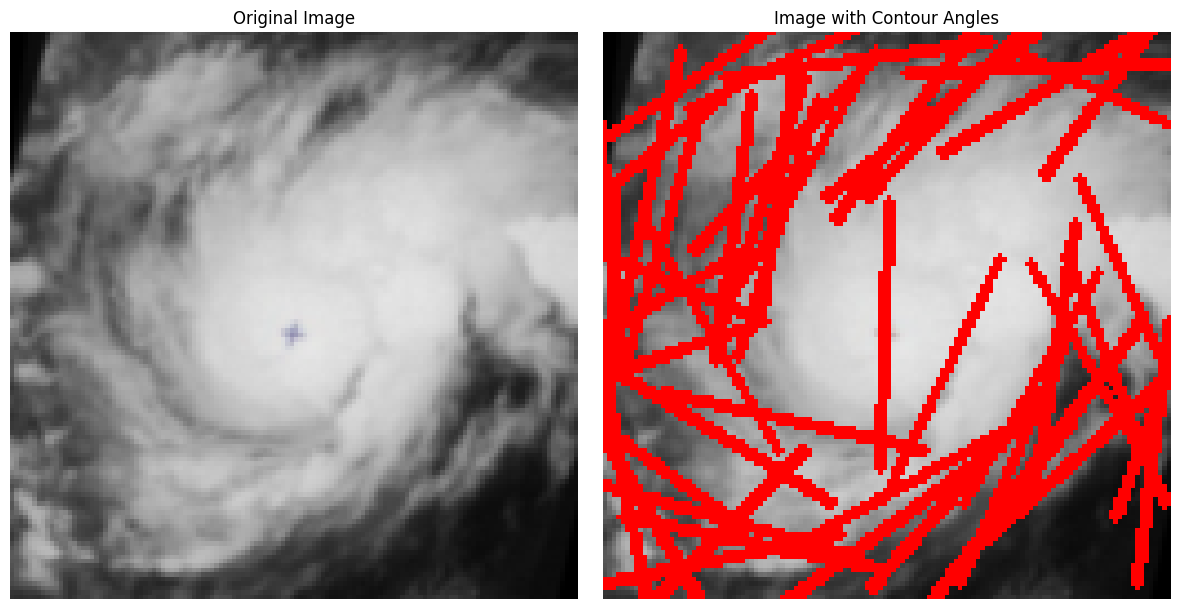

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize edges and angles on the image
def visualize_edges_and_angles(image_tensor):
    edges, angles = extract_edges_and_angles(image_tensor)

    # Convert image tensor back to numpy for visualization
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy() * 255.0  # Scale back to [0, 255]
    image_np = image_np.astype(np.uint8)

    # Convert the image to BGR format for plotting with OpenCV
    image_with_angles = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Get contours from edges for overlay
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Plot lines along the contours based on angles
    for i, contour in enumerate(contours):
        if len(contour) >= 5:
            # Fit a line to the contour and find the angle
            [vx, vy, x, y] = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            angle = np.arctan2(vy, vx)

            # Draw a line segment based on the angle
            length = 30  # Length of the line segment
            x1 = int(x - length * vx)
            y1 = int(y - length * vy)
            x2 = int(x + length * vx)
            y2 = int(y + length * vy)

            # Draw the line on the image
            cv2.line(image_with_angles, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red line

    # Plot the original image and the image with angles
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Display the image with edges and angles overlay
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_with_angles, cv2.COLOR_BGR2RGB))
    plt.title("Image with Contour Angles")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and process the image
image_tensor = read_image("/content/drive/MyDrive/input/augmented_raw_/85_aug_3.jpg").float() / 255.0
image_tensor = transforms.Resize((128,128))(image_tensor)
visualize_edges_and_angles(image_tensor)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Sample edge_index_sample for demonstration
# Replace this with your actual edge_index_sample tensor
edge_index_sample = torch.tensor(np.argwhere(edges > 0).T, dtype=torch.long)  # Adjust based on your data

# Create a figure
plt.figure(figsize=(10, 10))

# Extract x and y coordinates
x_coords = edge_index_sample[0].numpy()
y_coords = edge_index_sample[1].numpy()

# Mark all points in one go for efficiency
plt.scatter(x_coords, y_coords, color='gray', s=100)  # Increase size for better visibility

# Create an array to hold the lines to plot
lines = []

# Connect all edges with mesh lines
for j in range(edge_index_sample.shape[1]):
    for k in range(edge_index_sample.shape[1]):
        if k != j:  # Avoid connecting to itself
            lines.append((x_coords[j], y_coords[j], x_coords[k], y_coords[k]))

# Plot all lines at once
for line in lines:
    plt.plot([line[0], line[2]], [line[1], line[3]], color='gray', linewidth=0.5)

# Adjust limits for better visibility
plt.title("Mesh Representation of All Edges")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(-1, max(x_coords) + 1)  # Adjust limits based on your data
plt.ylim(-1, max(y_coords) + 1)
plt.grid()
plt.show()


#Model Architecture

In [ ]:
# Define the GNN model for regression with dropout
class GNNImageRegressor(nn.Module):
    def __init__(self, in_channels: int = 3, hidden_dim: int = 152, num_classes: int = 1, dropout_rate: float = 0.5):
        super().__init__()

        self.conv1 = GATConv(in_channels=in_channels, out_channels=hidden_dim)
        self.conv2 = GATConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = GATConv(in_channels=in_channels + hidden_dim, out_channels=hidden_dim)

        self.fc = nn.Sequential(
            nn.Linear(459, 256),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 32),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(32, num_classes),
        )

    def forward(self, node_features: torch.Tensor, edge_indices: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        x0 = node_features
        x1 = self.conv1(x0, edge_indices, edge_attr)
        x2 = self.conv2(x1, edge_indices, edge_attr)
        x0_x2 = torch.cat((x0, x2), dim=-1)
        x3 = self.conv3(x0_x2, edge_indices, edge_attr)
        x0_x1_x2_x3 = torch.cat((x0, x1, x2, x3), dim=-1)

        features = x0_x1_x2_x3.mean(dim=0, keepdim=True)
        logits = self.fc(features)
        return logits

# Custom RMSE loss function
def rmse_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# Training the Model

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100, Loss (RMSE): 61.61799509385053
Epoch 2/100, Loss (RMSE): 54.119366253123566
Epoch 3/100, Loss (RMSE): 35.64309669943417
Epoch 4/100, Loss (RMSE): 33.03324441348805
Epoch 5/100, Loss (RMSE): 33.70130118201761
Epoch 6/100, Loss (RMSE): 29.10561696220847
Epoch 7/100, Loss (RMSE): 31.035889120662915
Epoch 8/100, Loss (RMSE): 33.66768691119026
Epoch 9/100, Loss (RMSE): 29.425862256218405
Epoch 10/100, Loss (RMSE): 28.797626607558307
Epoch 11/100, Loss (RMSE): 32.04342931859634
Epoch 12/100, Loss (RMSE): 31.107203371384564
Epoch 13/100, Loss (RMSE): 29.75294253405403
Epoch 14/100, Loss (RMSE): 30.262022074531107
Epoch 15/100, Loss (RMSE): 30.577290310579187
Epoch 16/100, Loss (RMSE): 29.59157433229334
Epoch 17/100, Loss (RMSE): 25.161831238690546
Epoch 18/100, Loss (RMSE): 27.140207290649414
Epoch 19/100, Loss (RMSE): 24.400999405804804
Epoch 20/100, Loss (RMSE): 30.265811246984146
Epoch 21/100, Loss (RMSE): 31.704869550817154
Epoch 22/100, Loss (RMSE): 24.65813373116886
Epoch 2

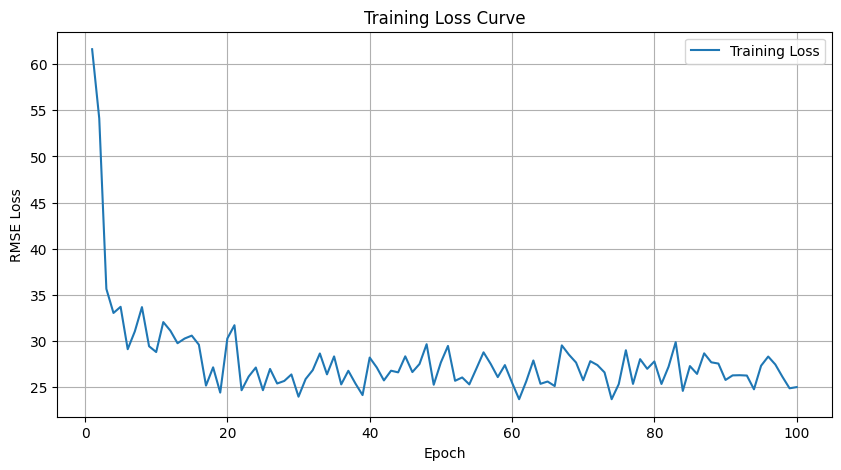

In [ ]:


# Load data
data_list = load_data(image_dir, excel_file)

# Create data loader
data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = GNNImageRegressor(in_channels=3, hidden_dim=152, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in data_loader:
        batch.x = batch.x.to(device)
        batch.edge_index = batch.edge_index.to(device)
        batch.edge_attr = batch.edge_attr.to(device)
        batch.y = batch.y.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(batch.x, batch.edge_index, batch.edge_attr)

        # Calculate loss using RMSE
        loss = rmse_loss(output, batch.y.view(-1, 1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss (RMSE): {avg_loss}')

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()



# Predict Intensity

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
from torchvision.transforms import transforms
from torch_geometric.data import Data
from torchvision.io import read_image

# Function to extract edges and their angles from an image
def extract_edges_and_angles(image):
    image_np = image.permute(1, 2, 0).cpu().numpy() * 255.0  # Convert to [0, 255] range
    image_np = image_np.astype(np.uint8)

    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    angles = []

    for contour in contours:
        if len(contour) >= 5:
            [vx, vy, x, y] = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            angle = np.arctan2(vy, vx) * (180.0 / np.pi)
            angles.append(angle)

    angles = np.array(angles)
    return edges, angles

# Function to predict a single image
def predict_image(model, image_path, device):
    # Read and preprocess the image
    image = read_image(image_path).float() / 255.0
    image = transforms.Resize((64, 64))(image)

    node_features = image.permute(1, 2, 0).reshape(-1, image.shape[0])
    edges, angles = extract_edges_and_angles(image)

    edge_index = torch.tensor(np.argwhere(edges > 0).T, dtype=torch.long)
    edge_index = torch.stack((edge_index[0], edge_index[1]))

    num_edges = edge_index.size(1)
    edge_attr = torch.tensor(angles[:num_edges], dtype=torch.float).view(-1, 1) if num_edges > 0 else torch.empty((0, 1), dtype=torch.float)

    if edge_attr.shape[0] < num_edges:
        edge_attr = torch.cat([edge_attr, torch.zeros(num_edges - edge_attr.shape[0], 1, dtype=torch.float)])
    elif edge_attr.shape[0] > num_edges:
        edge_attr = edge_attr[:num_edges]

    # Create a PyTorch Geometric data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    data = data.to(device)

    # Get prediction from the model
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index, data.edge_attr)
        prediction = output.cpu().numpy()

    return prediction

# Example usage of predict_image function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = '/content/drive/MyDrive/input/augmented_raw_/85_aug_4.jpg'  # Path to your image
predicted_value = predict_image(model, image_path, device)
print("Predicted value:", predicted_value)


Predicted value: [[63.88545]]


# Scatter plot representing the effectiveness

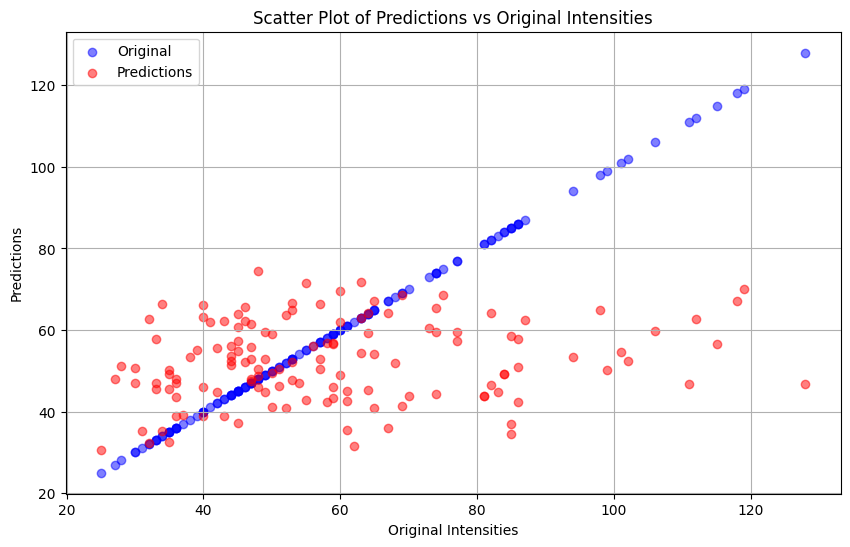

In [ ]:
def plot_scatter_for_all_images(image_dir, excel_file, model, device):
    df = pd.read_csv(excel_file)
    predictions = []
    orginal=[]

    # Load all images and make predictions
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['img_name'])

        prediction = predict_image(model, img_path, device)
        predictions.append(prediction)

        orginal.append(int(row['label']))


    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Plot original values in blue
    plt.scatter(orginal, orginal, color='blue', alpha=0.5, label='Original')

    # Plot predicted values in red
    plt.scatter(orginal, predictions, color='red', alpha=0.5, label='Predictions')

    # Add title and labels
    plt.title("Scatter Plot of Predictions vs Original Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predictions")

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()


# Example usage=
image_dir = '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL'
excel_file = '/content/drive/MyDrive/input/insat_3d_ds-Sheet.csv'
plot_scatter_for_all_images(image_dir, excel_file, model, device)
